# Setup

Before running any code, you will need to setup your codespace to work with Jupyter notebooks. Codespaces will do this for you when you try to run the first code cell. Click `Shift + Enter` in the following code cells, and follow the prompts at the top and/or bottom right of you page to install the python and jupyter extensions needed to run this notebook.

Select `Install/Enable suggested extensions python + jupyter` when it appears at the top of your page, and/or the "Install" button for the python extension on the bottom right of your page.

A circuluar arrow that looks like a clock will appear at the bottom left of your code cell while these install. This will take a minute or so. A circular arrow icon will also rotate near/in the top menu of your jupyter notebook.

After it installs, you will either need to select the "Select Kernel" button at the top right of your notebook, or it will ask you to Select Kernel at the top of your page (it may select a kernel automatically,in which case it will say "Python..." or "gprMax..."). You need to run this notebook on the gprMax kernel. Click Select Kernel at the top right to select your kernel. Then, click Python Environments in the dropdoxn and the gprMax environment. Once everything is working correctly, the cell below should output the text in the parentheses just below the cell. 

In [45]:
import gprMax
print("My python environment is now working correctly! I am ready to run gprMax!")

My python environment is now working correctly! I am ready to run gprMax!


# A-scan from a metal cylinder (2D)
This notebook is heavily derived from GPRMax's tutorial notebooks, but with some key parameter changes.

This example is the GPR modelling equivalent of 'Hello World'! It demonstrates how to simulate a single trace (A-scan) from a metal cylinder buried in a dielectric half-space. The input for this model is located in the file: /workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_GPRMaxFiles/GEOL451_Ascan_2D.in

### Geometry of a metal cylinder buried in a dielectric half-space
<img style="float: left" src="/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/gprMax/tools/Jupyter_notebooks/cylinder_half_space_geo.png" width="50%" height="50%" />


The geometry of the scenario is relatively simple:
* The white area at the top is "free-space" (for our purposes, the air)
* The brown area is the subsurface (also referred to as the half-space)
* The black area is a metal cylinder we will attempt to detect
* The semi-transparent area around the boundary of the domain represents the PML (i.e, the edge of area being modeled) region. 
* The red cell is the source of the GPR signal (where it is generated)
* The blue cell is the receiver for the GPR signal (where it is measured).

For this initial example a detailed description of what each command in the input file does and why each command was used is given. The following steps will explain the process of building the .in input file.

# Q1: Where is the origin of the coordinate system (0,0) for the 2D model shown above?

## 1. Determine the model's materials

There will be three different materials in the model: 
* Air: air (free space) already exists as a built-in material in gprMax which can be accessed using the ``free_space`` identifier.
* A buried target (in this case, a metal cylinder):  the metal cylinder will be modeled as a Perfect Electric Conductor, a built-in material in gprMax that can be accessed using ``pec``. 
* Dielectric half-space (a consistent subsurface material): we will define with the following parameters and an identifier of ``half_space``:
  * Non-magnetic: $\mu_r=1$ and $\sigma_*=0$ 
  * Relative permittivity of six: $\epsilon_r=6$ (this is a reasonable value for a sandy till, for example)
  * Zero conductivity, $\sigma=0$. 

We will get into the details about how these are defined later


## 2. Determine the source type and excitation frequency

We will simulate the GPR antenna/source with the following characteristics:
* A theoretical Hertzian dipole source 
* A Ricker waveform
  * Amplitude of 1
  * Center frequency of $f_c=250~\textrm{MHz}$

In the .in parameter file, these are specified using:
  * `#waveform: ricker 1 250e6 my_ricker`
  * `#hertzian_dipole: z 0.100 0.170 0 my_ricker`

The Ricker waveform is created with the ``#waveform`` command, specifying an amplitude of 1, centre frequency of 250 MHz and picking an arbitrary identifier of ``my_ricker``. The Hertzian dipole source is created using the ``#hertzian_dipole`` command, specifying a z direction polarisation (perpendicular to the survey direction if a B-scan were being created), location on the surface of the slab, and using the Ricker waveform already created.

The location of the receiving antenna is also specified in the .in file:
`#rx: 0.140 0.55 0`



## 3. Calculate a spatial resolution and domain size

One *rule-of-thumb* for GPR is that the spatial resolution is 1/10 of the smallest wavelength present in the signal. 

To determine the smallest wavelength, we will do a rough calculation of the highest frequency and lowest velocity present in the model. 

**The highest frequency is ***not*** the centre frequency of the Ricker waveform!**

You can use the following code to plot builtin waveforms and their FFTs.

Waveform characteristics...
Type: ricker
Maximum (absolute) amplitude: 1
Centre frequency: 2.5e+08 Hz
Time to centre of pulse: 5.65685e-09 s
Time window: 1.1e-08 s (5712 iterations)
Time step: 1.926e-12 s


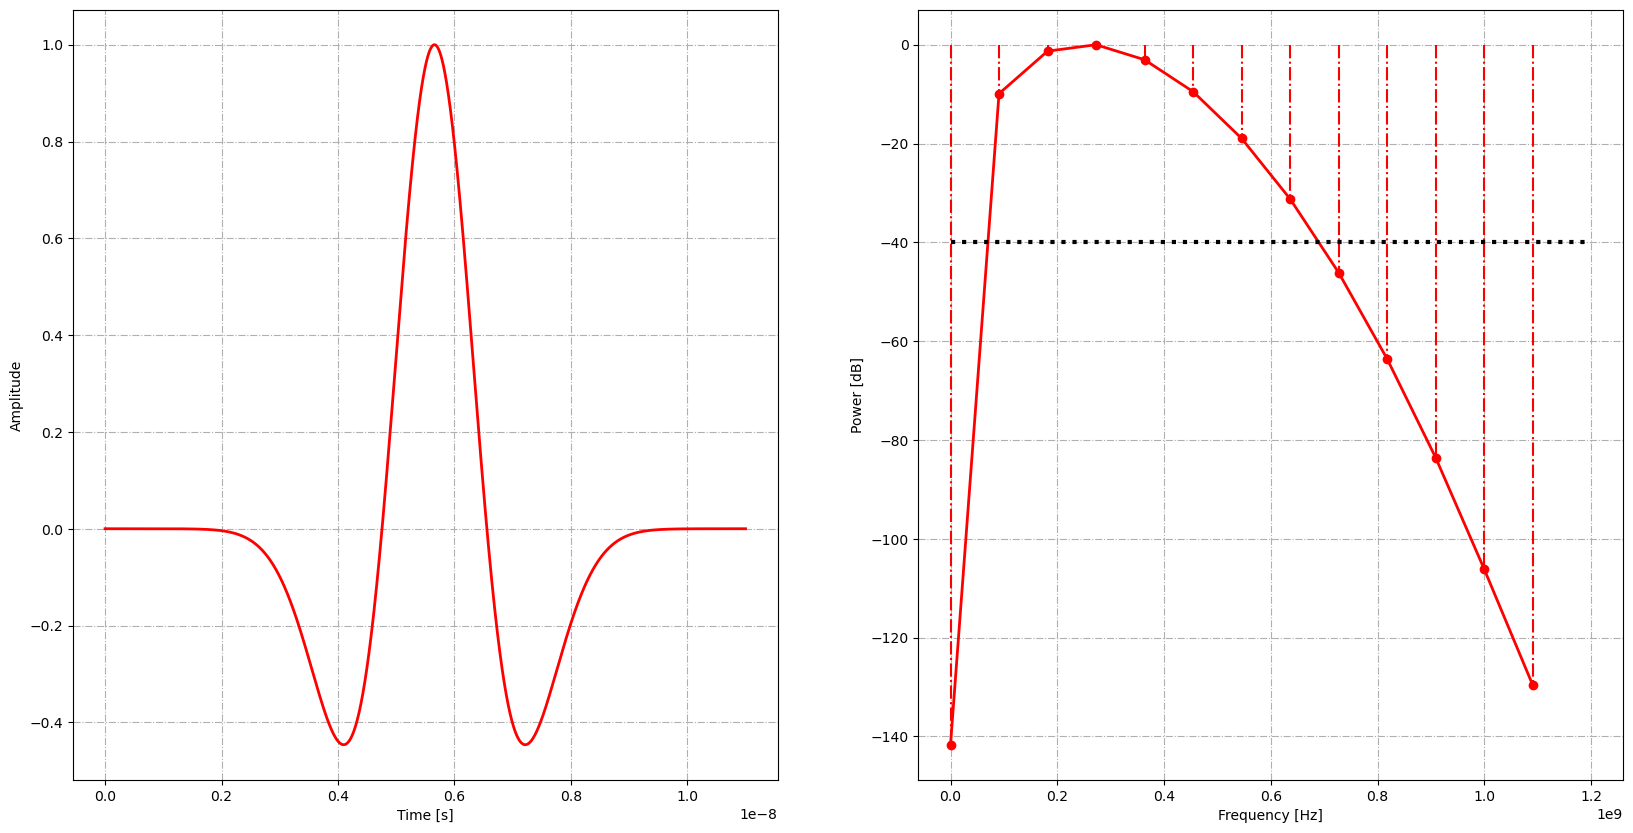

In [111]:
%matplotlib inline
from gprMax.waveforms import Waveform
from tools.plot_source_wave import check_timewindow, mpl_plot
import matplotlib.pyplot as plt

w = Waveform()
w.type = 'ricker'
w.amp = 1
w.freq = 250e6
timewindow = 1.1e-8
dt = 1.926e-12

timewindow, iterations = check_timewindow(timewindow, dt)
plt.close()
plt = mpl_plot(w, timewindow, dt, iterations, fft=True)
plt.hlines(y=[-40], xmin=0, xmax=1.2e9, linestyles='dotted', linewidths=3, colors='k')
plt.show()

The figure on the left shows the shape of the GPR pulse emitted from the transmitting antenna, and how much time it takes to complete a pulse at our input frequency of 250 MHz. The shape of this pulse is what the "ricker" type of waveform refers to. 

Things to note about the GPR signal: 
* It takes a little over 10 nanoseconds (1e-8 or 10e-9 seconds) for the pulse to complete
* The "peak" of the pulse round 5.65 nanoseconds (i.e., it takes 5.65 nanoseconds for our main pulse to even start)

The figure on the right shows the power at each frequency from the GPR pulse. This figure also includes a dotted line showing our (somewhat arbitrary) threshold for significant frequencies (i.e., those above -40dB). The frequencies with power values above this line are ~50MHz-700MHz (with a peak around our center frequency of 250MHz).

In this case the highest significant frequency present in the model is likely to be around 700MHz (0.7 GHz, or 0.7e9 Hz). To calculate the wavelength at 700 MHz in the half-space (which has the lowest velocity) use:

$$\lambda = \frac{c}{f \sqrt{\epsilon_r}}$$

In [40]:
from math import sqrt

# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 6

# Maximum frequency present in model
fmax = 700e6

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution, using our 1/10 rule of thumb
dmin = wmin * (1 / 10)


print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))

Minimum wavelength: 0.174843 m
Maximum spatial resolution: 0.0174843 m


This would give a minimum spatial resolution of 17 mm. However, the diameter of the cylinder is 20 mm so would be resolved to essentially a single cell if we used our GPR resolution (17 mm) as our model resolution. 

Therefore a better choice for resulution might be 2 mm, which resolves the diameter of the rebar to 9 or so model cells. This is shown in the .in file as:

    * `#dx_dy_dz: 0.002 0.002 0.002`

The domain size should be enough to enclose the volume of interest, plus allow 10 cells for the edge of the model to "absorb" the GPR signal and approximately another 10 cells of between the edge of the model and any objects of interest. Since we will create a B-scan of this scenario below, our domain should be large enough for those parameters. 

To make this is a 2D model (instead of a 3D model), will define one cell as "infinite" by making it only one cell wide. This is how this is implemented in the gprMax input file:

    * `#domain: 0.240 0.210 0.002`

## 4. Factors that affect the speed (and shape) of light

### Determine propogation velocity

GPR is a in the radio range of electromagnetic waves (i.e., it travels at the speed of light in a vaccum).

The speed of light in a vaccum is 299,792,458 meters per second. This is, however, **not** how fast GPR pulses usually travel.

The speed of GPR waves is affected by the medium through which they pass. Electromagnetic waves do not travel at the "standard" speed of light through the ground. The way we can calculate this is:

$$V_{medium} = \frac{c}{\sqrt{\epsilon_r}} $$

Where:
* $V_{medium}$  is the propogation of our GPR signal through a specific medium
* $c$  is the speed of light in a vaccum
* $\epsilon_r$  is the relative permittivity of the medium

See [here](https://gpg.geosci.xyz/content/GPR/GPR_fundamental_principles.html) for more information.

That is to say, the relative permittivity is the main characteristic of the medium affecting the speed of propogation of the GPR signal through the subsurface.

Above, we specified the relative permittivity as $\epsilon_r$ = 6. Using this, calculate the propogation velocity below (both in seconds and nanoseconds).

In [ ]:
from math import sqrt

# Speed of light in a vaccum 
# Speed of light in vacuum (m/s)
c = 299792458

### Fill in the relativey permittivity value of 6 here
er = 

# Use the equation above to calculate the propogation velocity for non-magnetic material
#### Fill in equation here
prop_vel = 
prop_vel_mpns = prop_vel / 1e9 # Convert propogation velocity to meters/nanoseconds (commonly used for GPR)

print(f'Propogation velocity: {prop_vel_mpns:.3f} m/ns')

# Q1: What is the propogation velocity (preferably in meters / nanosecond) of the GPR pulse in our material with a relative permittivity of 6?


### Create the GPR materials/objects

Now physical objects can be created for the half-space (i.e., the subsurface) and a target for our GPR pulse: a metal cylinder. 

First the ``#box`` command will be used to create the half-space (which is the subsurface material). We will also (explained later) use the ``#cylinder`` command to overwrite the properties of the half-space with those of the cylinder at the location of the cylinder. In the .in file, the half-space is defined as follows:

  * `#box: 0 0 0 0.240 0.170 0.002 half_space`

The `box` specifies a subsurface box that goes from the (0,0,0) coordinate (i.e., the bottom left) to the (0.240, 0.170, 0.002) coordinate (the top right...remember the Z dimension is only 1 cell wide and is considered infinite by gprMax). It uses the `half_space` material also defined in the .in file as follows:

`#material: 6 0 1 0 half_space`

Or, a relative permittivity of 6, conductivity of 0, is non-magnetic (relative permeability of 1), and magnetic loss of 0

See the next paragraph about how the cylinder is specified.


### Choose a time window

In this model, we hope to model and see the expected reflection of a GPR signal from a buried metal cylinder, therefore the time window must be long enough to allow the electromagnetic waves to propagate from the source through the half-space to the cylinder *and* to be reflected back to the receiver.

In our .in file, we specify the location and material of the cylinder as follows:

`#cylinder: 0.120 0.1 0 0.120 0.1 0.002 0.05 pec`

The format is as follows: #cylinder x1 y1 z1 x2 y2 z2 r material
* x1 y1 z1: location of the center of one face cylinder
* x2 y2 z2: location of the center of the other face of the cylinder
* r: radius of the cylinder
* material: the material (`pec` in this case is a prespecified material (perfect electrical conductor), i.e., metal)

So, the cylinder is 
* 0.12 meters into the model space (x) 
* 0.1 meters above the bottom of the model space (y; the coordinates increase from the bottom up)
* 0-0.002m fills the entire third dimension (which is just to reiterate that this is a 2D model)
* 0.05 m (5 cm) radius (or 10 cm wide)

# QUESTION: Read the bullet points below to answer the question: 
# Q2: How deep is the ***top*** of the metal cylinder in the subsurface/half-space of the model?

* The entire model domain is 0.6 m tall (i.e., it is 0.6 m in the y direction). 
* The subsurface part of the model (i.e., the half-space of the model) is 0.55 m deep (starting from the bottom model domain). 
* The center of the cylinder is 0.1 meters above the bottom of the model domain 
* The **radius** of the cylinder is 0.05 m.

# User your answer from Q2 as the value for the target_depth variable in the next cell

In [ ]:
### Your answer for Q2 here
target_depth = 

two_way_travel_time = (2 * target_depth) / (c / sqrt(6)) # 2 times the depth (we need two-way travel time) divided by velocity
print('Minimum time window: {:g} s'.format(two_way_travel_time))

This is the minimum time required, but we also want to make sure we see the entire waveform. If we add approximately 10 ns (i.e., the approximate width of the waveform), we can then specify the folloing for the wave form in the .in file:

`#time_window: 17e-9`

The time step required for the model is automatically calculated by the gprMax software.

# Run the model and view results

## Running the model

### Terminal Command
The simplest way to run models with gprMax is to create a .in parameter file and call the gprMax module with that file as input, as follows:
   
`python -m gprMax user_models/cylinder_Ascan_2D.in`

In this command: 
* `python` tells the terminal we are using python.
* `-m` indicates that we are running a python module
* `gprMax` is the name of the python module, which needs a .in parameter filename as it's first argument
* `user_models/cylinder_Ascan_2D.in` is the filepath (relative from the working directory in this case) to the .in parameter file

**Tip**: You can use the ``--geometry-only`` command line argument to build a model and produce any geometry views but not run the simulation. This option is useful for checking the geometry of the model is correct.

### Python API
Another way to run gprMax is to use the python API.

To do this, you need to import the gprMax package, and the gprMax module (the main part of the gprMax package).

In the code cell below, we do this using a using the `from ... import ...` statement, which imports a package directory based on where the code is being run. In order for this to work, you need to be running your code in the same directory as the main gprMax package (the package is a special folder with python scripts in this case).

So, the line `from gprMax.gprMax import api` below tells python to look in the gprMax folder for a gprMax.py file and in that file use a function called `api()`. This `api()` funtion takes as its first required argument a filename (just as in the terminal command above). You can optionally input other parameters, but your main modeling parameters will still be specified in your .in parameter file.

So that we can easily and consistently run everything in python in this jupyter notebook, we will use the `api()` command in the next cell to run our model.

## Plot the A-scan

When we run the `api()` command, it should produce an output file ``cylinder_Ascan_2D.out`` in the same directory as the .in file. 

Using a terminal command, we can view the results using:

`python -m tools.plot_Ascan user_models/cylinder_Ascan_2D.out`
    
We will use the the python implementation of this: the `mpl_plot` function of the `tools.plot_Ascan` module.

Run the cell below to run an A-Scan (1D) model and view the output (we are doing both the model run and plotting in the same cell)


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method 

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.7 (Big Smoke)

 Copyright (C) 2015-2023: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the
  terms of the GNU General Public License as published by the Free Software
  Foundation, either version 3 of the License, or (at your option) any later
  version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
  A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License along with
  gpr

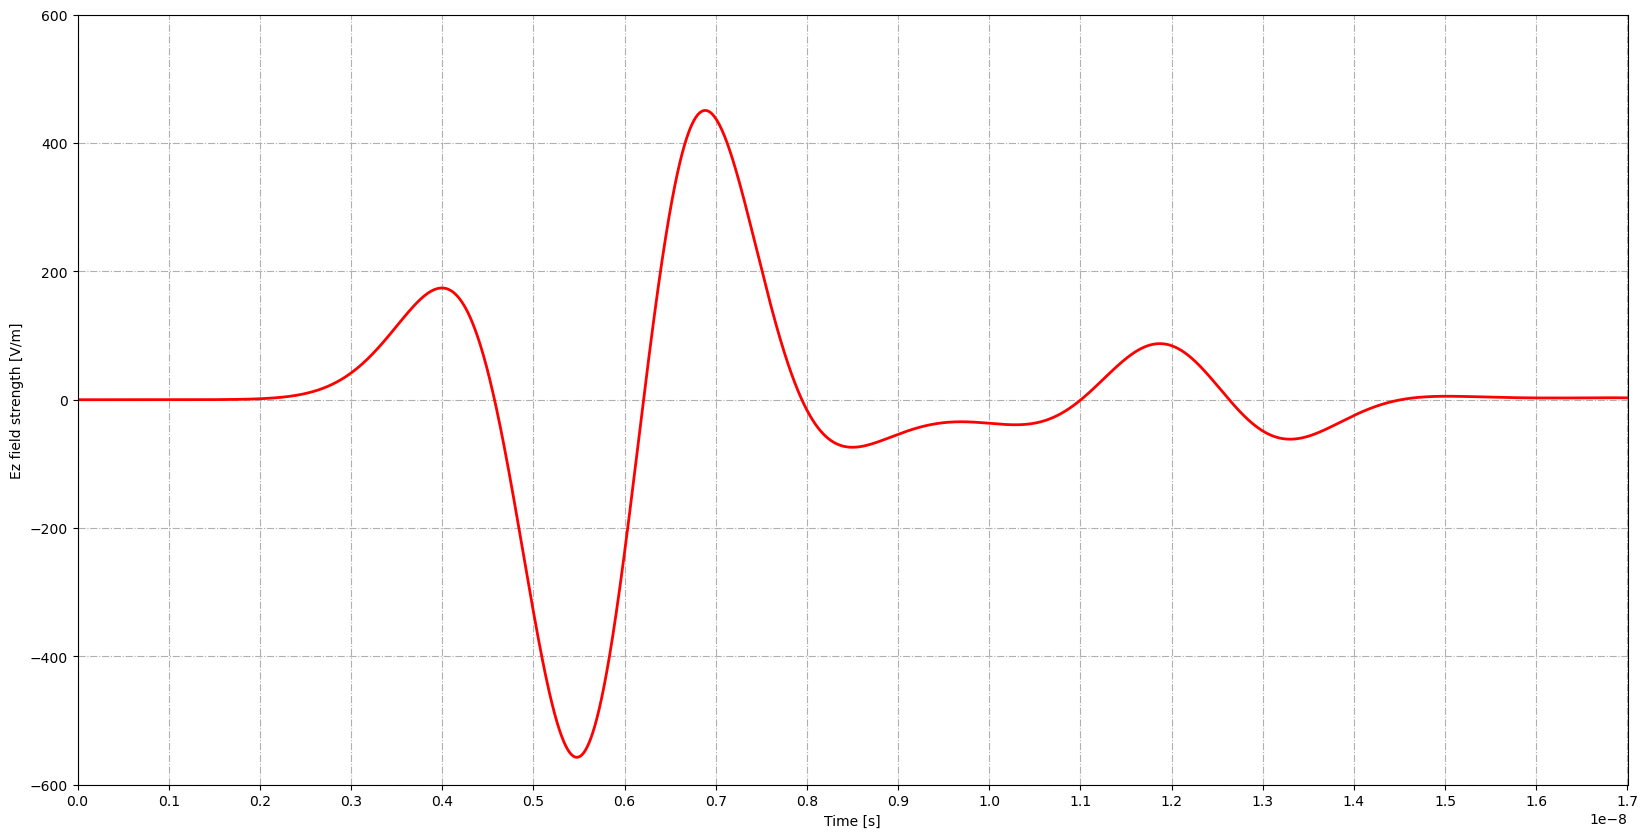

In [59]:

# Import necessary packages/modules for running the model
from gprMax.gprMax import api

# Run the model
parameter_filepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_Ascan_2D.in"
api(parameter_filepath, n=1, geometry_only=False)


# Import necessary packages/modules for plotting/visualization
%matplotlib inline
from gprMax.receivers import Rx
from tools.plot_Ascan import mpl_plot
import matplotlib.pyplot as plt

# Show the results
outputFilepath = r"/workspaces/GEOL451/GPR/SyntheticGPR/GPRMax/GEOL451_Ascan_2D.out"
outputs = Rx.defaultoutputs
#outputs = ['Ez']
plt.close()
plt = mpl_plot(outputFilepath, ["Ez"], fft=False)
plt.ylim([-600,600])
import numpy as np
plt.xticks(np.linspace(0, 1.7e-8, 18))
plt.show()

# A Scan Interpretation
In part to help you as we learn python, we are going to create a function to calculate the distance a pulse travels during its. 

The `def` word says that we are defining a function. We can then call the function whatever we want ('distance_from_peak_time' in this case) and add parameter names inside the parenthesis. We can give information about a function to users with docstrings (everything between the three quotes """). The entire function definition is indented, and the return statement defines what the function "spits out" when it is done. 

If the parameters are set equal to a value in the function definition, these are optional parameters and these values are their default values. Any parameter without a default value is a required parameter/argument and must be defined whenever calling the funtion. 

The function is called using the name of the function and setting the values of the parameters equal to some value. For example, if we wanted to call the function below with a travel_time of 0.5 seconds and set a variable `distanceCalc` equal to the resulting distance we calculate, we would do the following:

`distanceCalc = distance_from_peak_time(travel_time=0.5)`

In this case, the other parameters of the function that are not set to specific values in the parentheses take on their default values.

Run the cell below to define the function.

In [101]:
# Define a function to calculate 
def distance_from_peak_time(travel_time, waveform_peak_time= 5.656e-09, c=299792458.0, er=1.0):
    """This is a python function to calculate the distance a GPR pulse travels based on a travel_time we input.
    
    The parameters are define as follows (this is a standard format that allows computers to also read the docstrings).
    The item before the colon for each parameter is the name of the parameter. 
    The value after the colon is the expected data type.
    The second line (indented) of each parameter is a description of what it is.

    PARAMETERS
    ----------
    travel_time : float
        The time in seconds that it takes for the pulse of interest in our chart to peak
    waveform_peak_time : float
        The time in seconds that it takes for the original pulse itself to reach its highest amplitude
    c : float
        The speed of light in meters per second
    er : float
        The dielectric permittivity of the medium

    RETURNS
    -------
    float
        The approximate distance in meters the pulse has traveled.
    """

    # This is where the actual code begins
    from math import sqrt
    
    # Arrival time of initial part of wave
    # This is the difference between the amount of time it takes the peak to form and when it appears on the record
    corrected_peak_arrival_time = travel_time - waveform_peak_time

    distance_traveled = abs(corrected_peak_arrival_time * (c / sqrt(er)))
    print(f'Distance pulse traveled: {distance_traveled:.3f} meters ({distance_traveled*100:.2f} cm)')
    
    return distance_traveled

The signal pulse starts at 0. The largest magnitude peak occurs at--roughly interpreting the chart--about 5.5 nanseconds (5.5e-9 seconds), when the plot dips down to nearly -600 V/m. Use the next code cell to calculate the distance to this "object".

Set the `travel_time` parameter of the `distance_from_peak_time()` function equal to this peak value we read from the chart in the cell below. Don't change the other parameters for now.

In [ ]:
distance_from_peak_time(travel_time=5.5e-9)

You should have gotten a result of about 0.047 m or 4.68 cm (if not, make sure your units are correct)

There is great deal of uncertainty in the propogation characteristics at these very short distances, but we can use this value to talk about the scale of our distance.

### For the next few questions, we will be referring back to the depth of the top of our target. Just to jog your own memory, please refer back to your answer to question 2 to remind yourself what the depth to the top of the target is in the model.

We will be comparing our next few answers to that depth

# Q3: Why do you think we got an answer of 4 or 5 cm for the distance traveled by the largest peak in the reading from the receiving antenna, when we know our target to be much deeper?
Hint: Why did we also not change our er value from the default of 1, which is the dielectric permittivity value of air.
(You do not need to get the correct answer here, I would rather you turn in a thoughtful response (even if you change your mind later))

Now, let's run the same function again, except, this time let's use the *second set* of peaks (the largest of which occurs between 11 nanoseconds (1.1e-8 seconds) and 13 nanoseconds (1.3 e-8 seconds). 

Enter the time value (in seconds) as the `travel_time` parameter in the `distance_from_peak_time()` function. This time, we will set our dielectric permittivity parameter to 6 as well (er=6).

In [ ]:
# Fill in the time in seconds of the largest of the second set of peaks between 11 and 13 nanoseconds
distance_from_peak_time(travel_time=, er=6)

# Q4: What value did you use for travel_time (i.e., the total time the wave traveled before it reached the receiving antenna)? What was the distance you calculated that it travelled?

# Q5: The result you got back from this last code cell should be approximately twice the distance of the depth to the top of the target you recorded in Question 2. Why is this?